In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from models._utils import load_model_checkpoint
from data._utils import create_combined_dataset, split_combined_dataset
from utils import DEVICE, NEURONS_302, VALID_DATASETS, SYNTHETIC_DATASETS, init_random_seeds

# Initialize the random seeds
init_random_seeds(42)

CUDA device found.


In [4]:
model_before_train = torch.load(
    "/om2/user/qsimeon/worm-graph/logs/hydra/2024_01_28_18_01_59/exp0/train/checkpoints/model_epoch_0.pt",
    map_location=DEVICE,
)

model_after_train = torch.load(
    "/om2/user/qsimeon/worm-graph/logs/hydra/2024_01_28_18_01_59/exp0/train/checkpoints/model_best.pt",
    map_location=DEVICE,
)

model = load_model_checkpoint(
    "/om2/user/qsimeon/worm-graph/logs/hydra/2024_01_28_18_01_59/exp0/train/checkpoints/model_best.pt"
)
print(model)

LinearRegression(
  (identity): Identity()
  (input_hidden): Sequential(
    (0): Embedding(2048, 302)
  )
  (hidden_hidden): Identity()
  (inner_hidden_model): InnerHiddenModel(
    (hidden_hidden): Identity()
  )
  (latent_embedding): Embedding(2048, 302)
  (linear): Linear(in_features=302, out_features=2048, bias=True)
  (layer_norm): LayerNorm((302,), eps=1e-05, elementwise_affine=True)
)


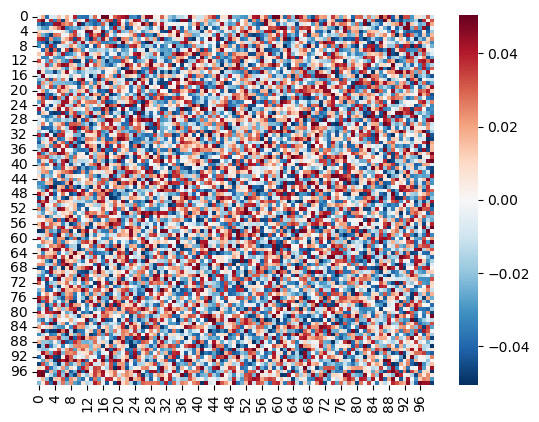

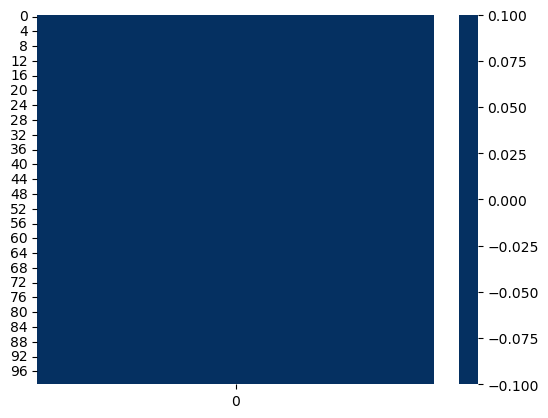

In [5]:
weights = model_before_train["model_state_dict"]["linear.weight"].cpu().numpy()
biases = model_before_train["model_state_dict"]["linear.bias"].cpu().unsqueeze(-1).numpy()

sns.heatmap(weights[:100, :100], cmap="RdBu_r", center=0)
plt.show()
sns.heatmap(biases[:100], cmap="RdBu_r", center=0)
plt.show()

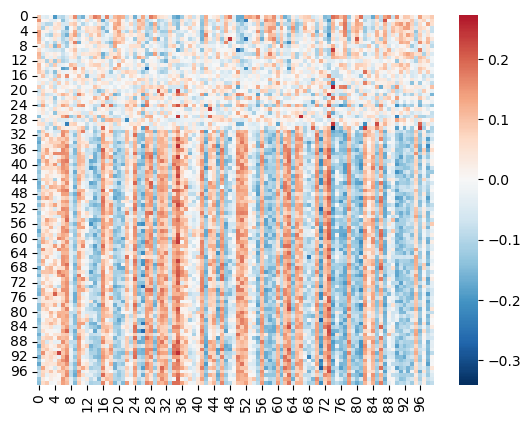

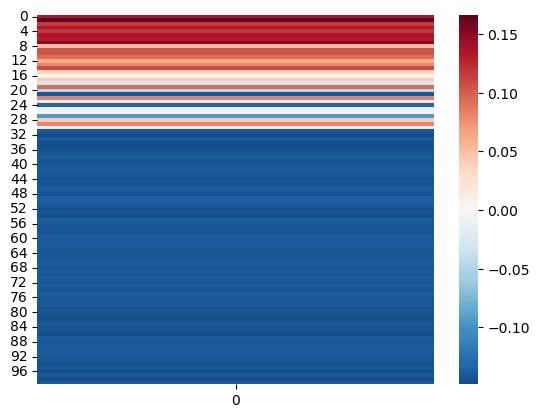

In [6]:
weights = model_after_train["model_state_dict"]["linear.weight"].cpu().numpy()
biases = model_after_train["model_state_dict"]["linear.bias"].cpu().unsqueeze(-1).numpy()

sns.heatmap(weights[:100, :100], cmap="RdBu_r", center=0)
plt.show()
sns.heatmap(biases[:100], cmap="RdBu_r", center=0)
plt.show()

In [1]:
%%time

# Create a single combined dataset from the one of the 8 experimental datasets of your choice
experimental_dataset = "Shakespeare0000"
assert experimental_dataset in set(VALID_DATASETS) | set(SYNTHETIC_DATASETS), f"Invalid dataset: {experimental_dataset}"
datasets = {experimental_dataset: 1}  # a real worm neural dataset (1 worm)
combined_dataset, dataset_info = create_combined_dataset(
    datasets, num_named_neurons=None
)
num_worms = len(combined_dataset)

# Split the datsaet into train and validation halves
num_train_samples = num_test_samples = num_samples = 2
reverse = use_residual = False
smooth_data = True
train_split_first = False
train_split_ratio = 0.5
seq_len = 180
train_dataset, test_dataset, timestep_info = split_combined_dataset(
    combined_dataset,
    num_train_samples,
    num_test_samples,
    seq_len,
    reverse,
    use_residual,
    smooth_data,
    train_split_first,
    train_split_ratio,
)

NameError: name 'VALID_DATASETS' is not defined

In [ ]:
%%time


# Get inputs and targets from dataloaders and outputs from model
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

with torch.no_grad():
    X_train, Y_train, mask_train, metadata_train = next(iter(train_loader))
    time_train = metadata_train["time_vec"]
    if model.version_2:
        tokens = model.tokenize_neural_data(Y_train.to(DEVICE), mask_train.to(DEVICE))
        Y_pred_train = model.neural_embedding[tokens]
    else:
        Y_pred_train = model(X_train.to(DEVICE), mask_train.to(DEVICE))
    print(
        f"\nX:{X_train.shape}\nY:{Y_train.shape}\nmask:{mask_train.shape}\ntime:{time_train.shape}\n"
    )

    X_test, Y_test, mask_test, metadata_test = next(iter(test_loader))
    time_test = metadata_test["time_vec"]
    if model.version_2:
        tokens = model.tokenize_neural_data(Y_test.to(DEVICE), mask_test.to(DEVICE))
        Y_pred_test = model.neural_embedding[tokens]
    else:
        Y_pred_test = model(X_test.to(DEVICE), mask_test.to(DEVICE))
    print(
        f"\nX:{X_test.shape}\nY:{Y_test.shape}\nmask:{mask_test.shape}\ntime:{time_test.shape}\n"
)

In [ ]:
%%time

# Set up the matplotlib figure for two columns of subplots
max_neurons_to_plot = 10
num_neurons_train, num_neurons_test = mask_train.sum().item(), mask_test.sum().item()
num_neurons = min(max_neurons_to_plot, num_neurons_train, num_neurons_test)
fig, axes = plt.subplots(num_neurons, 2, figsize=(15, 10), sharey="row")

# Plot data for each half
for col, phase in enumerate(["train", "test"]):
    # Convert the data to NumPy arrays if they are not already
    time = eval(f"time_{phase}.squeeze().cpu().numpy()")
    X = eval(f"X_{phase}.detach().squeeze().cpu().numpy()") # input
    Y = eval(f"Y_{phase}.squeeze().cpu().numpy()") # target
    Y_pred = eval(f"Y_pred_{phase}.detach().squeeze().cpu().numpy()") # output
    mask = eval(f"mask_{phase}.detach().squeeze().cpu().numpy()")
    worm_dataset = eval(f"metadata_{phase}['worm_dataset']")
    wormID = eval(f"metadata_{phase}['wormID']")

    # Set offsets for the target data
    y_offset_step = 5
    x_offset = len(time) / 50

    # Get the indices of the neurons to plot
    neurons_to_plot = np.where(mask)[0][:num_neurons]

    data_fragments = []

    for i, neuron_idx in enumerate(neurons_to_plot):
        neuron_label = NEURONS_302[neuron_idx]

        # Collect input data
        input_df = pd.DataFrame(
            {
                "Time": time,
                "Value": X[:, neuron_idx],
                "Type": "Input",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(input_df)

        # Collect target data with time offset
        target_df = pd.DataFrame(
            {
                "Time": time
                + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y[:, neuron_idx],
                "Type": "Target (+ offset)",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(target_df)

        # Collect output data with time offset
        output_df = pd.DataFrame(
            {
                "Time": time
                + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y_pred[:, neuron_idx],
                "Type": "Model Output",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(output_df)

    # Concatenate all fragments to create the full DataFrame
    df = pd.concat(data_fragments, ignore_index=True)

    # Plot the lines
    for i, neuron_label in enumerate(neurons_to_plot):
        sns.lineplot(
            data=df[df["Neuron"] == NEURONS_302[neuron_label]],
            x="Time",
            y="Value",
            hue="Type",
            ax=axes[i, col],
            palette="tab10",
            alpha=0.7,
            errorbar=None,
        )
        axes[i, col].set_ylabel(NEURONS_302[neuron_label])
        axes[i, col].get_legend().remove()

        # Set the x-axis label to empty
        axes[i, col].set_xlabel("")

        # Hide x-axis labels and ticks for all but the last row
        if i < num_neurons - 1:
            axes[i, col].set_xticklabels([])
            axes[i, col].set_xticks([])
        else:
            axes[i, col].set_xlabel("Time (s)")

        # Set title only for the first row of each column
        if i == 0:
            axes[i, col].set_title(f"{phase.capitalize()} half")
        else:
            axes[i, col].set_title("")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display name of dataset and worm as suptitle
fig.suptitle(f"{worm_dataset} {wormID}", fontsize=14)

# Display the legend outside the rightmost plot
handles, labels = axes[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.show()

In [ ]:
# DEBUG

all_unique_vectors = torch.vstack([tup[0] for tup in list(train_dataset)]).unique(dim=0)
learned_unique_vectors = model.neural_embedding.unique(dim=0)
print(all_unique_vectors.shape, learned_unique_vectors.shape)
print()

all_unique_vectors = {tuple(row.round(decimals=3).cpu().numpy()) for row in all_unique_vectors}
learned_unique_vectors = {
    tuple(row.round(decimals=3).cpu().numpy()) for row in learned_unique_vectors
}
print(f"There are {len(all_unique_vectors)} unique embeddings that generated the neural data.")
print(
    f"The model learned {len(learned_unique_vectors)} unique neural embeddings. But are they the same?"
)
print()

inter = all_unique_vectors.intersection(learned_unique_vectors)
diff = all_unique_vectors - learned_unique_vectors
print(f"Model learned to reproduce {len(inter)}/{len(all_unique_vectors)} embeddings exactly.")
print(f"The remaining {len(diff)}/{len(all_unique_vectors)} are superpositions of embeddings!")
print()